In [1]:
# Funciones generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para entrenamiento y validación
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Copia de archivos
import shutil

# Creación de CNN
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPooling2D, Dropout #type:ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type:ignore

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array #type:ignore
import os


2025-08-30 15:26:03.833988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-30 15:26:03.997154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756585564.087603  103423 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756585564.157125  103423 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756585564.263707  103423 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Extrayendo los datos de Kaggle

In [2]:
import kagglehub

import kagglehub
path_kaggle_dataset = kagglehub.dataset_download('jessicali9530/lfw-dataset')

# Ruta al archivo CSV
csv_path = os.path.join(path_kaggle_dataset, 'lfw_allnames.csv')
df_faces_dataset = pd.read_csv(csv_path)
df_faces_dataset.head()

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1


In [3]:
# creando las rutas de cada imagen
rutas_images = df_faces_dataset.loc[df_faces_dataset.index.repeat(df_faces_dataset.images)]
rutas_images["ruta_img"] = rutas_images.groupby("name").cumcount() + 1
rutas_images["ruta_img"] = rutas_images["ruta_img"].apply(lambda x: f"{x:04}")
rutas_images["ruta_img"] = rutas_images["name"] + "/" + rutas_images["name"] + "_" + rutas_images["ruta_img"] + ".jpg"
rutas_images = rutas_images.drop("images", axis=1)
rutas_images.head()

,name,ruta_img
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg


                name  cantidad
0      George_W_Bush       530
1       Colin_Powell       236
2         Tony_Blair       144
3    Donald_Rumsfeld       121
4  Gerhard_Schroeder       109
5       Ariel_Sharon        77


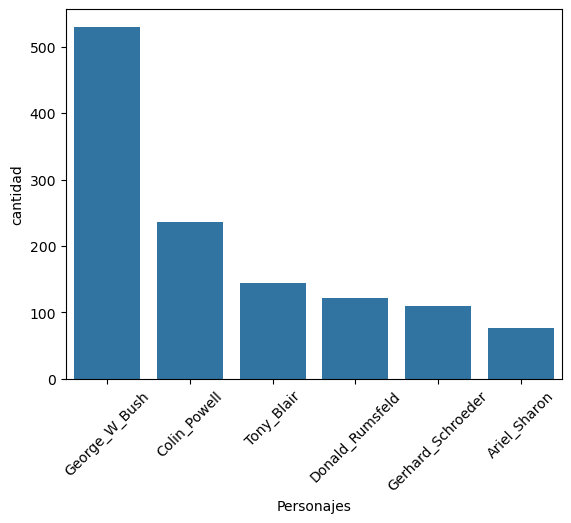

In [4]:
top_names = rutas_images.name.value_counts().head(6).reset_index(name="cantidad")
print(top_names)
sns.barplot(data=top_names, x="name", y="cantidad")
plt.xlabel("Personajes")
plt.xticks(rotation=45)
plt.show()

### Balanceando los datos de acuerdo a la menor cantidad de imagenes (Ariel_Sharon)

Segmentando los datos a balancear

In [5]:
names = top_names.name.tolist()
rutas_images_top = rutas_images.loc[rutas_images["name"].isin(names)]

                name  cantidad
0       Ariel_Sharon        77
1       Colin_Powell        77
2    Donald_Rumsfeld        77
3      George_W_Bush        77
4  Gerhard_Schroeder        77
5         Tony_Blair        77


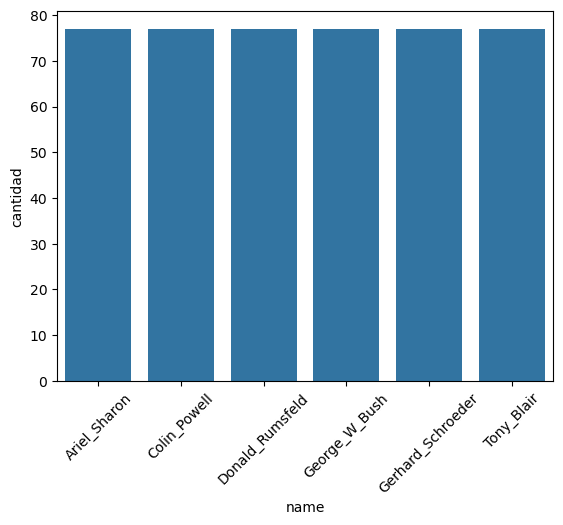

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(rutas_images_top[["ruta_img"]], rutas_images_top[["name"]])
print(y_rus.value_counts().reset_index(name="cantidad"))
sns.barplot(y_rus.value_counts().reset_index(name="cantidad"), x="name", y="cantidad")
plt.xticks(rotation=45)
plt.show()

Creando el dataframe con los datos balanceados

In [7]:
rutas_images_top_rus = pd.concat([y_rus, X_rus], axis=1).reset_index(drop=True)
rutas_images_top_rus.head()

,name,ruta_img
0,Ariel_Sharon,Ariel_Sharon/Ariel_Sharon_0001.jpg
1,Ariel_Sharon,Ariel_Sharon/Ariel_Sharon_0002.jpg
2,Ariel_Sharon,Ariel_Sharon/Ariel_Sharon_0003.jpg
3,Ariel_Sharon,Ariel_Sharon/Ariel_Sharon_0004.jpg
4,Ariel_Sharon,Ariel_Sharon/Ariel_Sharon_0005.jpg


## Separando los valores de entrenamiento y prueba

In [8]:
names_train, names_test = train_test_split(rutas_images_top_rus,
                                            test_size=0.2, random_state=42, stratify=rutas_images_top_rus["name"])

## Visualizando algunas imágenes

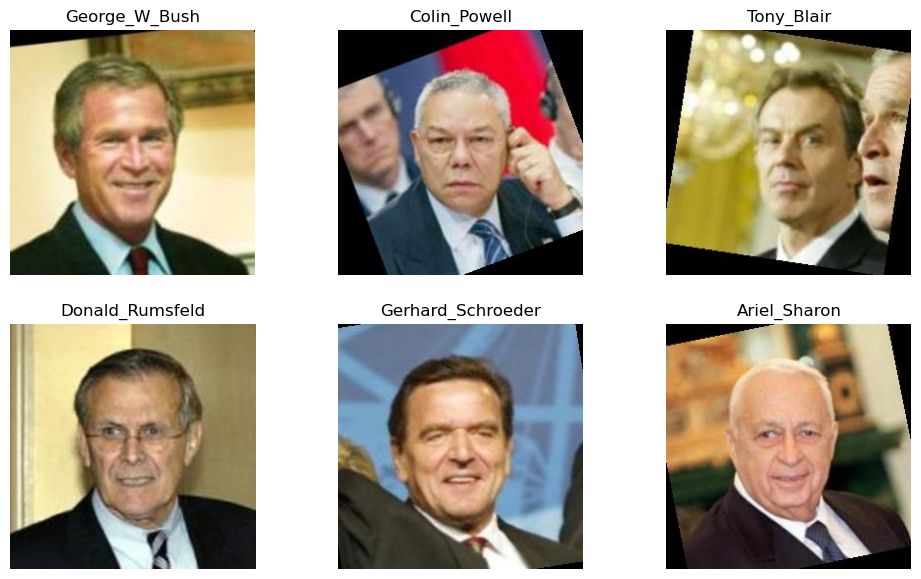

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
ax = ax.flat
for i, name in enumerate(names):
    imagen = rutas_images_top_rus.loc[rutas_images_top_rus["name"] == name, "ruta_img"].iloc[0]
    ruta_imagen = os.path.join(path_kaggle_dataset, "lfw-deepfunneled/lfw-deepfunneled", imagen)
    imagen_load = load_img(ruta_imagen)
    ax[i].imshow(imagen_load)
    ax[i].set_title(name)
    ax[i].axis("off")
plt.show()

## Separando una carpeta para cada personaje

In [10]:
import shutil

def make_dir(data, ruta):
    count = 0

    for i in data.ruta_img:
        if not os.path.exists(os.path.join("../../../../../data_main", ruta)):
            os.mkdir(os.path.join("../../../../../data_main", ruta))
        name_dir = data.loc[data["ruta_img"]==i]["name"]
        name_dir = str(list(name_dir)[0])
        if not os.path.exists(os.path.join("../../../../../data_main", ruta, name_dir)):
            os.mkdir(os.path.join("../../../../../data_main", ruta, name_dir))
        data_from = os.path.join(path_kaggle_dataset, "lfw-deepfunneled/lfw-deepfunneled", str(i))
        data_to = os.path.join("../../../../../data_main", ruta, name_dir)
        shutil.copy(data_from, data_to)
        count += 1

    print(f"Se movieron {count} imágenes a la carpeta {ruta}")

make_dir(names_train, "names_train/")
make_dir(names_test, "names_test/")

Se movieron 369 imágenes a la carpeta names_train/
Se movieron 93 imágenes a la carpeta names_test/


## Implementación de la red neuronal convolucional

In [11]:
# Estableciendo los callbacks con el cual se optimiza el modelo
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler]

In [12]:
model_conv = Sequential()
model_conv.add(Input((128,128,3)))
model_conv.add(Conv2D(filters=6, kernel_size=(5,5), activation="relu"))
model_conv.add(MaxPooling2D(pool_size=(2,2)))

model_conv.add(Conv2D(filters=16, kernel_size=(5,5), activation="relu"))
model_conv.add(MaxPooling2D(pool_size=(2,2)))

model_conv.add(Flatten())
model_conv.add(Dense(120, activation="relu"))
model_conv.add(Dense(84, activation="relu"))
model_conv.add(Dense(6, activation="softmax"))

I0000 00:00:1756585579.480958  103423 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
# model_conv = Sequential()
# model_conv.add(Input((128,128,3)))
# model_conv.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
# model_conv.add(MaxPooling2D(pool_size=(2,2)))
# model_conv.add(Dropout(0.5))

# model_conv.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
# model_conv.add(MaxPooling2D(pool_size=(2,2)))

# model_conv.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
# model_conv.add(MaxPooling2D(pool_size=(2,2)))

# model_conv.add(Flatten())
# model_conv.add(Dense(256, activation="relu"))
# model_conv.add(Dropout(0.5))
# model_conv.add(Dense(6, activation="softmax"))

### compilando el modelo

In [14]:
model_conv.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

set_train = train_datagen.flow_from_directory("../../../../../data_main/names_train/",
                                                       target_size=(128,128),
                                                       batch_size=32,
                                                       class_mode="categorical")
set_test = test_datagen.flow_from_directory("../../../../../data_main/names_test/",
                                                  target_size=(128,128),
                                                  batch_size=5,
                                                  class_mode="categorical")

Found 369 images belonging to 6 classes.
Found 93 images belonging to 6 classes.


## Entrenamiento del modelo

In [16]:
history_conv = model_conv.fit(set_train,
                              epochs=18,
                              validation_data=set_test,
                              callbacks=callbacks)

/home/leonardope/mambaforge/envs/estudio/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/18


I0000 00:00:1756585583.367903  103664 service.cc:152] XLA service 0x7ab774006930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756585583.368033  103664 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-30 15:26:23.439351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756585583.709697  103664 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-30 15:26:25.054492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_329', 76 bytes spill stores, 76 bytes spill loads

2025-08-30 15:26:25.576920: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2422 - loss: 2.3671 

I0000 00:00:1756585594.674345  103664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 4/12 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2148 - loss: 2.5838

2025-08-30 15:26:35.977566: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_329', 4 bytes spill stores, 4 bytes spill loads

2025-08-30 15:26:36.519730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_329', 56 bytes spill stores, 56 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - accuracy: 0.1382 - loss: 2.1881 - val_accuracy: 0.1613 - val_loss: 1.7853 - learning_rate: 0.0010
Epoch 2/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.1897 - loss: 1.7798 - val_accuracy: 0.1720 - val_loss: 1.7749 - learning_rate: 0.0010
Epoch 3/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.2466 - loss: 1.7583 - val_accuracy: 0.3118 - val_loss: 1.7297 - learning_rate: 0.0010
Epoch 4/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3442 - loss: 1.6776 - val_accuracy: 0.3548 - val_loss: 1.6363 - learning_rate: 0.0010
Epoch 5/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.4092 - loss: 1.5515 - val_accuracy: 0.4086 - val_loss: 1.4793 - learning_rate: 0.0010
Epoch 6/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4634 - loss: 1.4352 - val_accuracy: 0.4409 - val_loss: 1.4249 - learning_rate: 0.0010
Epoch 7/18
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5257 - loss: 1.2987 - val_accura

## Graficando las métricas de Accuracy y Loss

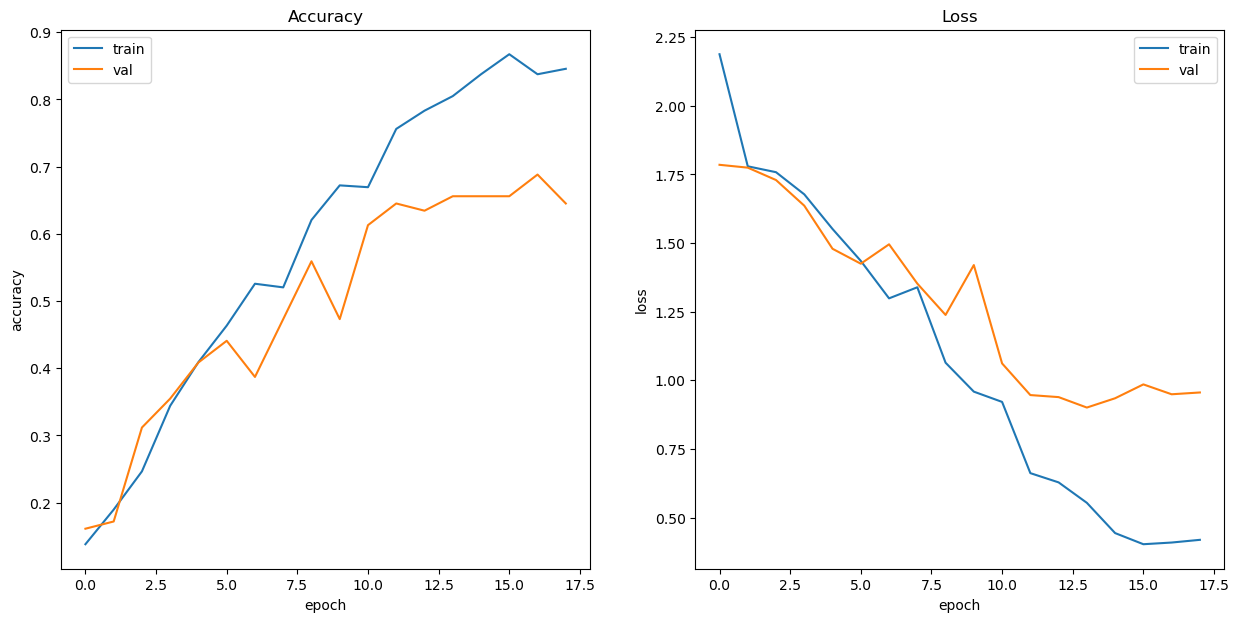

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(history_conv.history['accuracy'])
ax[0].plot(history_conv.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history_conv.history["loss"])
ax[1].plot(history_conv.history["val_loss"])
ax[1].set_title("Loss")
ax[1].set_ylabel("loss")
ax[1].set_xlabel("epoch")
ax[1].legend(["train", "val"], loc="upper right")
plt.show()

In [18]:
from collections import OrderedDict
names = []
# obteniendo todos los nombres de los archivos de set_test.filenames en una lista
for i in range(len(set_test.filenames)):
    names.append(set_test.filenames[i])
# extrayendo el primer nombre de cada archivo
for i in range(len(names)):
    names[i] = names[i].split("/")[0]
# eliminación de duplicados y se convierte a una lista
names = list(OrderedDict.fromkeys(names))
values = range(len(names))
guia = {value: name for value, name in zip(values, names)}
guia

{0: 'Ariel_Sharon',
 1: 'Colin_Powell',
 2: 'Donald_Rumsfeld',
 3: 'George_W_Bush',
 4: 'Gerhard_Schroeder',
 5: 'Tony_Blair'}

## Realizando las predicciones

In [19]:
# función para predicciones
def make_predict(ruta, model, binary):
    predictions = []
    for i in os.listdir(ruta):
        test_image = load_img(ruta + "/" + str(i), target_size=(128,128))
        test_image = img_to_array(test_image)
        # se añade una dimensión mas 
        test_image = np.expand_dims(test_image, axis=0)
    
        if binary is True:
            result = float(model.predict(test_image, verbose=0)[0][0])
        else:
            result = int(np.argmax(model.predict(test_image, verbose=0)))
        predictions.append(result)
    return predictions

# Especificando las rutas de los directorios de prueba de cada personaje
rutas = {f"ruta_{name.rsplit('_')[-1:][0]}": os.path.join("../../../../../data_main/names_test/", guia[i]) for name, i in zip(names,guia.keys())}
# Realizando la predicción de cada personaje
predicciones = {f"prediccion_{name.rsplit('_')[-1:][0]}": make_predict(ruta, model_conv, binary=False) for name, ruta in zip(names, rutas.values())}
# Reemplazando los valores obtenidos por los nombres de los personajes
predicciones_nombres = {clave: [guia[val] for val in lista] for clave, lista in predicciones.items()}

# for clave, lista in predicciones_nombres.items():
#     f"{clave}: {lista}\n"

In [20]:
# Uniendo todos los valores de las predicciones en una lista de listas
valores_predicciones = []
for valor in predicciones_nombres.values():
    valores_predicciones.append(valor)

# Uniendo todos los valores reales en una lista de listas
valores_reales = [[guia[i]]*len(valores_predicciones[i]) for i in range(0,6)]

In [21]:
# Uniendo las listas de listas de las predicciones y valores reales
valores_predict_lista = np.array([name for lista in valores_predicciones for name in lista])
valores_reales_lista = np.array([name for lista in valores_reales for name in lista])
valores_predict_lista.shape, valores_reales_lista.shape

((93,), (93,))

In [22]:
# Creando el dataframe con las listas creadas
valorers_stack = np.stack((valores_predict_lista, valores_reales_lista), axis=1)
df_predicicones = pd.DataFrame(valorers_stack, columns=["Predicciones","Valores_reales"])

### Matriz de confusión

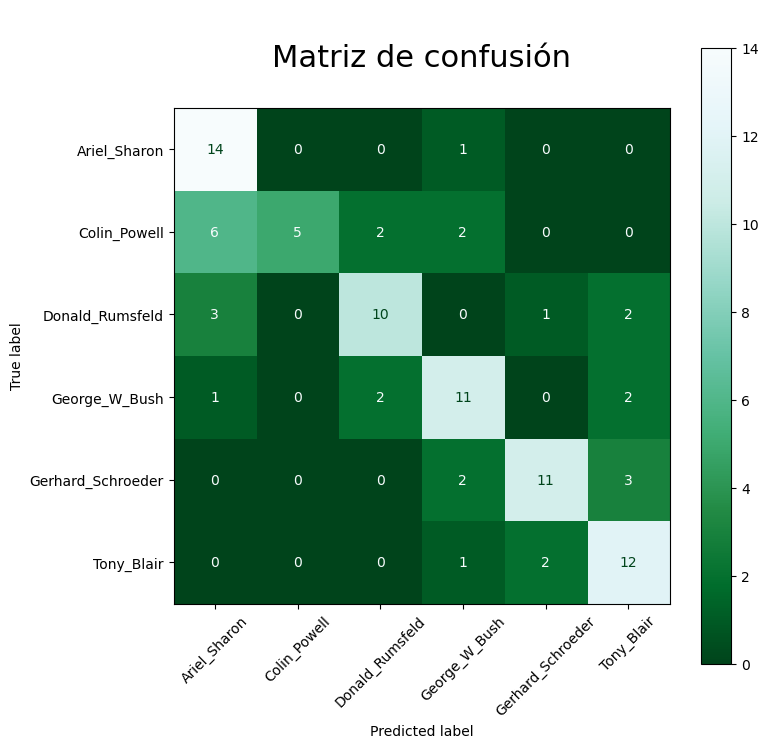

In [23]:
cm = confusion_matrix(df_predicicones["Valores_reales"], df_predicicones["Predicciones"])
disp = ConfusionMatrixDisplay(cm, display_labels=list(guia.values()))

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="BuGn_r")                         
plt.title("\nMatriz de confusión\n", size=22)
plt.xticks(rotation=45)
plt.show()

## Evaluación del modelo

In [24]:
loss, accuracy = model_conv.evaluate(set_test, verbose=0)
print(f"Pérdida: {round(loss,2)}")
print(f"Precisión: {round(accuracy,2)*100}%")

Pérdida: 0.95
Precisión: 69.0%


## Guardando el mejor modelo

In [ ]:
# from tensorflow.keras.models import load_model #type:ignore

# model_conv.save("../../models/model_faces_categ.keras")

In [31]:
from sklearn.metrics import classification_report

matriz = classification_report(df_predicicones["Valores_reales"], df_predicicones["Predicciones"], target_names=guia.values())
print(matriz)

                   precision    recall  f1-score   support

     Ariel_Sharon       0.58      0.93      0.72        15
     Colin_Powell       1.00      0.33      0.50        15
  Donald_Rumsfeld       0.71      0.62      0.67        16
    George_W_Bush       0.65      0.69      0.67        16
Gerhard_Schroeder       0.79      0.69      0.73        16
       Tony_Blair       0.63      0.80      0.71        15

         accuracy                           0.68        93
        macro avg       0.73      0.68      0.67        93
     weighted avg       0.73      0.68      0.67        93

